In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

In [ ]:
def gpt_params(seq_len, vocab_size, d_model, num_heads, num_layers):
    """ 
    根据给定的GPT模型配置参数计算总参数量
    
    参数:
    - seq_len: 最大序列长度
    - vocab_size: 词汇表大小
    - d_model: 模型维度(隐藏层大小)
    - num_heads: 注意力头数量
    - num_layers:  transformer层数
    
    返回:
    - 模型总参数量
    """
    # 前馈网络大小，GPT中固定为4倍模型维度
    ffw_size = 4*d_model

    # 计算嵌入层参数量(通常不计入总参数量)
    # token嵌入和位置嵌入
    embeddings = d_model * vocab_size + d_model * seq_len
    
    # 单个注意力头的参数量计算
    # 3个线性层: 查询(Q)、键(K)、值(V)
    attention = 3*d_model**2 + 3*d_model  # 权重和偏置
    
    # 注意力投影层参数量
    attproj = d_model**2 + d_model
    
    # 前馈网络第一层参数量
    ffw = d_model*(ffw_size) + ffw_size
    
    # 前馈网络第二层参数量(投影回d_model)
    ffwproj = ffw_size*d_model + d_model
    
    # 两个层归一化层参数量(每层有γ和β参数)
    layernorms = 2*2*d_model
    
    # 最终层归一化参数量
    ln_f = 2*d_model
    
    # 输出层线性投影参数量(无偏置)
    dense = d_model*vocab_size
    
    # 计算总参数量(通常不包含嵌入层)
    # 每层包含: 注意力机制、注意力投影、前馈网络、层归一化
    # 加上最终层归一化和输出层
    total_params = num_layers*(attention + attproj + ffw + ffwproj + layernorms) + ln_f + dense
    
    return total_params

# GPT-2模型配置示例
gpt2 = dict(seq_len = 1024, vocab_size = 50257, d_model = 768, num_heads = 12, num_layers = 12)
# 输出参数量(以百万为单位)
print(f"GPT-2参数量: {gpt_params(**gpt2)/1e6:.2f}M")

GPT-2参数量: 123.65M


In [4]:
def chinchilla_params(seq_len, vocab_size, d_model, num_heads, num_layers, ffw_size):
    """ 
    根据给定的Chinchilla模型配置参数计算总参数量
    
    参数:
    - seq_len: 最大序列长度
    - vocab_size: 词汇表大小
    - d_model: 模型维度(隐藏层大小)
    - num_heads: 注意力头数量
    - num_layers: transformer层数
    - ffw_size: 前馈网络中间层维度
    
    返回:
    - 模型总参数量
    """
    # 仅计算token嵌入参数量(Chinchilla使用相对位置编码，不使用位置嵌入)
    embeddings = d_model * vocab_size
    
    # 单个注意力头的参数量计算
    # 3个线性层: 查询(Q)、键(K)、值(V)
    attention = 3*d_model**2 + 3*d_model  # 权重和偏置
    
    # 相对位置编码参数量
    # 相对位置键、内容偏置、相对偏置
    relative_pos = d_model**2 + 2*d_model
    
    # 注意力投影层参数量
    attproj = d_model**2 + d_model
    
    # 前馈网络第一层参数量
    ffw = d_model*ffw_size + ffw_size
    
    # 前馈网络第二层参数量(投影回d_model)
    ffwproj = ffw_size*d_model + d_model
    
    # 两个层归一化层参数量(每层有γ和β参数)
    layernorms = 2*2*d_model
    
    # 最终层归一化参数量
    ln_f = 2*d_model
    
    # 输出层线性投影参数量(无偏置)
    dense = d_model*vocab_size
    
    # 计算总参数量(通常不包含嵌入层)
    # 每层包含: 注意力机制、相对位置编码、注意力投影、前馈网络、层归一化
    # 加上最终层归一化和输出层
    total_params = num_layers*(attention + relative_pos + attproj + ffw + ffwproj + layernorms) + ln_f + dense
    
    return total_params

In [5]:
# Load in all the 50 Chinchilla models on the last page of the paper
import json
chinchilla_models_txt = '[[44000000.0, 512, 2048, 64, 8, 8], [57000000.0, 576, 2304, 64, 9, 9], [74000000.0, 640, 2560, 64, 10, 10], [90000000.0, 640, 2560, 64, 10, 13], [106000000.0, 640, 2560, 64, 10, 16], [117000000.0, 768, 3072, 64, 12, 12], [140000000.0, 768, 3072, 64, 12, 15], [163000000.0, 768, 3072, 64, 12, 18], [175000000.0, 896, 3584, 64, 14, 14], [196000000.0, 896, 3584, 64, 14, 16], [217000000.0, 896, 3584, 64, 14, 18], [251000000.0, 1024, 4096, 64, 16, 16], [278000000.0, 1024, 4096, 64, 16, 18], [306000000.0, 1024, 4096, 64, 16, 20], [425000000.0, 1280, 5120, 128, 10, 18], [489000000.0, 1280, 5120, 128, 10, 21], [509000000.0, 1408, 5632, 128, 11, 18], [552000000.0, 1280, 5120, 128, 10, 24], [587000000.0, 1408, 5632, 128, 11, 21], [632000000.0, 1536, 6144, 128, 12, 19], [664000000.0, 1408, 5632, 128, 11, 24], [724000000.0, 1536, 6144, 128, 12, 22], [816000000.0, 1536, 6144, 128, 12, 25], [893000000.0, 1792, 7168, 128, 14, 20], [1018000000.0, 1792, 7168, 128, 14, 23], [1143000000.0, 1792, 7168, 128, 14, 26], [1266000000.0, 2048, 8192, 128, 16, 22], [1424000000.0, 2176, 8704, 128, 17, 22], [1429000000.0, 2048, 8192, 128, 16, 25], [1593000000.0, 2048, 8192, 128, 16, 28], [1609000000.0, 2176, 8704, 128, 17, 25], [1731000000.0, 2304, 9216, 128, 18, 24], [1794000000.0, 2176, 8704, 128, 17, 28], [2007000000.0, 2304, 9216, 128, 18, 28], [2283000000.0, 2304, 9216, 128, 18, 32], [2298000000.0, 2560, 10240, 128, 20, 26], [2639000000.0, 2560, 10240, 128, 20, 30], [2980000000.0, 2560, 10240, 128, 20, 34], [3530000000.0, 2688, 10752, 128, 22, 36], [3802000000.0, 2816, 11264, 128, 22, 36], [4084000000.0, 2944, 11776, 128, 22, 36], [4516000000.0, 3072, 12288, 128, 24, 36], [6796000000.0, 3584, 14336, 128, 28, 40], [9293000000.0, 4096, 16384, 128, 32, 42], [11452000000.0, 4352, 17408, 128, 32, 47], [12295000000.0, 4608, 18432, 128, 36, 44], [12569000000.0, 4608, 18432, 128, 32, 47], [13735000000.0, 4864, 19456, 128, 32, 47], [14940000000.0, 4992, 19968, 128, 32, 49], [16183000000.0, 5120, 20480, 128, 40, 47]]'
chilchilla_models = json.loads(chinchilla_models_txt) # all 50 models
chilchilla_models[0] # tuples of params, d_model, ffw_size, kv_size, n_heads, n_layers from Table A9

[44000000.0, 512, 2048, 64, 8, 8]

In [6]:
for m in chilchilla_models[-5:]: # only print last 5 models of the table
    p, d, f, k, h, l = m
    nparams = chinchilla_params(seq_len = 1024, vocab_size = 32000, d_model = d, num_heads = h, num_layers = l, ffw_size=f)
    print(f"our estimated params: {nparams/1e6:.4f}M, chinchilla params: {p/1e6:.4f}M, d_model: {d}, n_heads: {h}, n_layers: {l}")

our estimated params: 12296.1623M, chinchilla params: 12295.0000M, d_model: 4608, n_heads: 36, n_layers: 44
our estimated params: 13124.4826M, chinchilla params: 12569.0000M, d_model: 4608, n_heads: 32, n_layers: 47
our estimated params: 14614.4279M, chinchilla params: 13735.0000M, d_model: 4864, n_heads: 32, n_layers: 47
our estimated params: 16037.5039M, chinchilla params: 14940.0000M, d_model: 4992, n_heads: 32, n_layers: 49
our estimated params: 16184.4582M, chinchilla params: 16183.0000M, d_model: 5120, n_heads: 40, n_layers: 47


In [7]:
def chinchilla_flops(seq_len, vocab_size, d_model, num_heads, num_layers, ffw_size):
    """ 
    Calculate total number of FLOPs, see Chinchilla 
    paper Appendix F as reference: https://arxiv.org/pdf/2203.15556.pdf
    """ 
    key_size = d_model // num_heads

    # embeddings
    embeddings = 2 * seq_len * vocab_size * d_model

    # attention
    # key, query, value projections
    attention = 2 * 3 * seq_len * d_model * (key_size * num_heads)
    # key @ query logits
    attlogits = 2 * seq_len * seq_len * (key_size * num_heads)
    # softmax
    attsoftmax = 3 * num_heads * seq_len * seq_len # 3* is for subtract (max), exp, divide (?)
    # softmax @ value reductions
    attvalue = 2 * seq_len * seq_len * (key_size * num_heads)
    # final linear
    attlinear = 2 * seq_len * (key_size * num_heads) * d_model
    att = attention + attlogits + attsoftmax + attvalue + attlinear
    # feed forward
    dense = 2 * seq_len * (d_model * ffw_size + d_model * ffw_size)

    # logits
    logits = 2 * seq_len * d_model * vocab_size
    
    # this is what you'd expect:
    # forward_flops = embeddings + num_layers * (att + dense) + logits
    # but:
    # per author correspondence apparently there is typo in the paper,
    # they do not count embeddings and logits to repro table 4. So instead:
    forward_flops = num_layers * (att + dense)
    backward_flops = 2 * forward_flops # as in Kaplan et al. 2020
    total_flops = forward_flops + backward_flops

    return total_flops


In [8]:
# Now try reproduce Table A4 from Chinchilla paper Appendix, 
# comparing accurate flops above to approximate flops F = 6*N*D
# note Chinchilla mentions using vocab_size = 32K

chilchilla_models_table4 = [
  [10, 640, 2560, 10, 64],
  [20, 1024, 4096, 16, 64],
  [24, 1280, 5120, 10, 128 ],
  [26, 1792, 7168, 14, 128 ],
  [28, 2048, 8192, 16, 128],
  [40,  3584, 14336, 28, 128]
]

rows = []
for num_layers, d_model, ffw_size, num_heads, _ in chilchilla_models_table4:

    args = dict(seq_len = 2048, vocab_size = 32000, d_model = d_model, 
                num_heads = num_heads, num_layers = num_layers, ffw_size=ffw_size)

    D = args['seq_len'] # dataset size (cancels anyway, for the purposes of the ratio calculation below)
    N = chinchilla_params(**args)
    F = chinchilla_flops(**args)

    approx_flops = 6*D*N # approximate flops
    chinch_flops = F * (float(D) / args['seq_len']) # exact flops according to Chinchilla paper calculations

    # print('---')
    # print(f"params: {N/1e6:.2f}M")
    # print(f"approx flops: {approx_flops/1e9:.2f}B")
    # print(f"chinchilla flops: {chinch_flops/1e9:.2f}B")
    # print(f"ratio (chinchilla / approx): {chinch_flops / approx_flops:.2f}")

    # first copy all keyvalues from args into out
    out = {k:v for k,v in args.items()}
    # then add the calculated values
    out['N'] = N
    out['F'] = F
    out['approx_flops'] = approx_flops
    out['chinch_flops'] = chinch_flops
    out['ratio'] = chinch_flops / approx_flops
    rows.append(out)

# make a pandas dataframe from rows
df = pd.DataFrame(rows)
df

,seq_len,vocab_size,d_model,num_heads,num_layers,ffw_size,N,F,approx_flops,chinch_flops,ratio
0,2048,32000,640,10,10,2560,73825280,929877196800,907165040640,9.298772e+11,1.025036
1,2048,32000,1024,16,20,4096,305707008,4135248199680,3756527714304,4.135248e+12,1.100817
2,2048,32000,1280,10,24,5120,552604160,7353453772800,6790399918080,7.353454e+12,1.082919
3,2048,32000,1792,14,26,7168,1143453696,14670316437504,14050759016448,1.467032e+13,1.044094
4,2048,32000,2048,16,28,8192,1593126912,20220437594112,19576343494656,2.022044e+13,1.032902
5,2048,32000,3584,28,40,14336,6796274688,83021046743040,83512623366144,8.302105e+13,0.994114


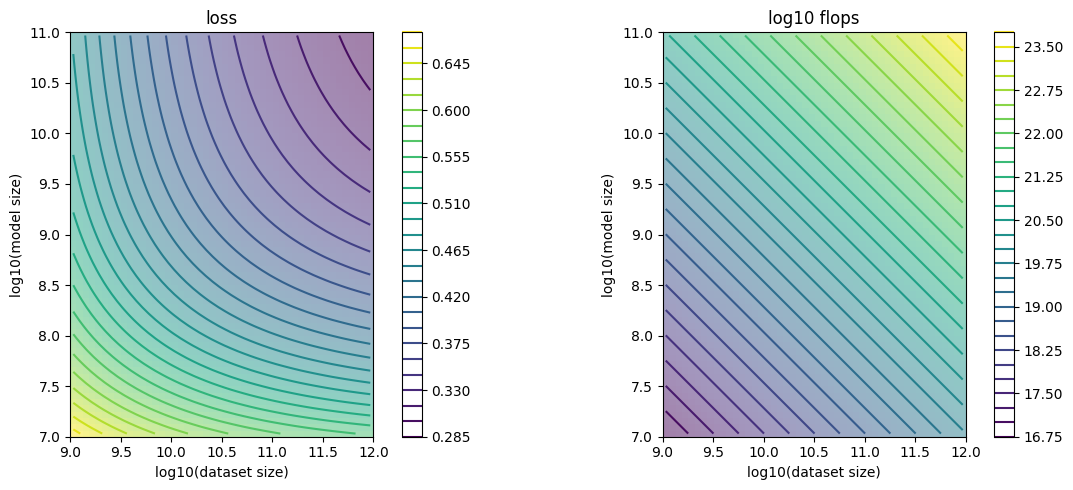

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def L(N, D):
    """ 
    根据Chinchilla论文中的缩放定律，给定参数量N和数据集大小D(以token为单位)，近似计算损失值
    
    参数:
    - N: 模型参数量
    - D: 训练数据集大小(单位: token)
    
    返回:
    - 估计的损失值
    """
    E = 1.69  # 自然语言的熵，即无限模型在无限数据上的损失下限
    A = 406.4 # 控制参数量对损失影响的系数
    B = 410.7 # 控制数据量对损失影响的系数
    alpha = 0.34 # 参数量的缩放指数
    beta = 0.28  # 数据量的缩放指数
    
    # 损失由三部分组成: 模型容量不足项、数据不足项和自然语言熵下限
    return A / (N ** alpha) + B / (D ** beta) + E

# 生成模型参数量范围(10M到100B，对数均匀分布)
ns = 10 ** np.arange(7, 11, step=2**-4)

# 生成数据集大小范围(1B到1T，对数均匀分布)
ds = 10 ** np.arange(9, 12, step=2**-4)

###########################################################
# 创建一个1行2列的图表布局
plt.figure(figsize=(12, 5))
# 绘制左图: 损失值的等高线图
plt.subplot(121)

# 计算所有(N,D)组合的损失值，并取对数以便更好地可视化
loss2d = np.log10(np.array([[L(n, d) for d in ds] for n in ns]))

# 使用imshow显示损失热图，使用contour绘制等高线
plt.imshow(loss2d, extent=[9, 12, 7, 11], origin='lower', alpha=0.5)
plt.contour(loss2d, levels=30, extent=[9, 12, 7, 11], origin='lower')

# 设置坐标轴标签和标题
plt.xlabel('log10(dataset size)')
plt.ylabel('log10(model size)')
plt.title('loss')
plt.colorbar()
###########################################################
# 绘制右图: 计算量(浮点运算次数)的等高线图
plt.subplot(122)

# 计算所有(N,D)组合的计算量(6*N*D是训练Transformer的经验公式)，并取对数
compute2d = np.log10(np.array([[6*n*d for d in ds] for n in ns]))

# 使用imshow显示计算量热图，使用contour绘制等高线
plt.imshow(compute2d, extent=[9, 12, 7, 11], origin='lower', alpha=0.5)
plt.contour(compute2d, levels=30, extent=[9, 12, 7, 11], origin='lower')

# 设置坐标轴标签和标题
plt.xlabel('log10(dataset size)')
plt.ylabel('log10(model size)')
plt.title('log10 flops')
plt.colorbar()

# 显示图表
plt.tight_layout()
plt.show()

最优模型参数量: 316.23M
最优数据集大小: 11.65B


D:\_resdata\sysTemp\ipykernel_11796\558443895.py:47: UserWarning: Glyph 27169 (\N{CJK UNIFIED IDEOGRAPH-6A21}) missing from current font.
  plt.tight_layout()
D:\_resdata\sysTemp\ipykernel_11796\558443895.py:47: UserWarning: Glyph 22411 (\N{CJK UNIFIED IDEOGRAPH-578B}) missing from current font.
  plt.tight_layout()
D:\_resdata\sysTemp\ipykernel_11796\558443895.py:47: UserWarning: Glyph 21442 (\N{CJK UNIFIED IDEOGRAPH-53C2}) missing from current font.
  plt.tight_layout()
D:\_resdata\sysTemp\ipykernel_11796\558443895.py:47: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  plt.tight_layout()
D:\_resdata\sysTemp\ipykernel_11796\558443895.py:47: UserWarning: Glyph 37327 (\N{CJK UNIFIED IDEOGRAPH-91CF}) missing from current font.
  plt.tight_layout()
D:\_resdata\sysTemp\ipykernel_11796\558443895.py:47: UserWarning: Glyph 25439 (\N{CJK UNIFIED IDEOGRAPH-635F}) missing from current font.
  plt.tight_layout()
D:\_resdata\sysTemp\ipykernel_11796\558443895.

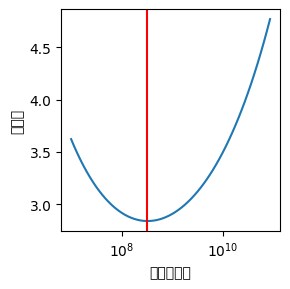

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# 假设损失函数L已在前面定义
def L(N, D):
    """ 
    根据Chinchilla论文中的缩放定律，给定参数量N和数据集大小D(以token为单位)，近似计算损失值
    """
    E = 1.69  # 自然语言的熵，即无限模型在无限数据上的损失下限
    A = 406.4 # 控制参数量对损失影响的系数
    B = 410.7 # 控制数据量对损失影响的系数
    alpha = 0.34 # 参数量的缩放指数
    beta = 0.28  # 数据量的缩放指数
    return A / (N ** alpha) + B / (D ** beta) + E

# 目标计算预算(浮点运算次数)
# 这个值来自Chinchilla论文Table A3的第一行
c = 2.21e19 

# 模型参数量扫描范围(从10M到100B)
ns = 10 ** np.arange(7, 11, step=2**-4)

# 根据计算预算约束C=6*N*D，计算每个模型大小对应的最优数据集大小
ds = c / (6 * ns)

# 计算每个(N,D)组合的损失值
losses = L(ns, ds)

# 找到使损失最小的模型参数量索引
best = np.argmin(losses)

# 打印最优模型参数量和数据集大小
print(f"最优模型参数量: {ns[best]/1e6:.2f}M")
print(f"最优数据集大小: {ds[best]/1e9:.2f}B")

# 绘制损失函数曲线
plt.figure(figsize=(3,3))
plt.plot(ns, losses)
plt.xscale('log')  # 使用对数坐标显示模型参数量

# 在最优模型参数量处绘制垂直线
plt.axvline(ns[best], color='red')

# 设置坐标轴标签
plt.xlabel('模型参数量')
plt.ylabel('损失值')
plt.tight_layout()
plt.show()